In [23]:
# Data-driven Newsvendor with Pricing
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
#Initalization
p = [] #price 
D = [] #demand


#Numerical experiment parameters
a = 0 #y-intercept or market size
b = 0 #coefficient of price
u = [] #estimation error term sampling
sigma = 0 #std of estimation error terms sampling

n = 250 #sample size
cv = 0.5 #coefficient of variance
c = 0.5 #procurement cost per unit
alpha = 0.9 #non-stockout probability

##Sampling range
lbp = 1 #lower bound of price
ubp = 1.5 #upper bound of price
lba = 1500 #lb of a
uba = 2000 #up of a
lbb = 500 #lb of b
ubb = 1000 #ub of b

# IMPLEMENTATION

We can divide the main problem into two subproblems as follows:  
1) to learn the relationship between demand/ ordering quantity and price   
2) to find optimal quantity and price   


## DEMAND/ ORDERING QUANTITY ESTIMATION (BEUTEL 2012)

**Reference:** Beutel, A. L., & Minner, S. (2012). *Safety stock planning under causal demand forecasting*. International Journal of Production Economics, 140(2), 637-645.

### Function to generate sampling of demand and price:
Demand is presented here as a function of price p: D(p) = a - b\*p + u.  
Demand - price observation set is built by randomly choose a, b, p and u. In more detail:
- market size a ~ U(1500, 2000)
- slope b ~ U(500, 1000)
- uniformly chosen sample of price p (with size = sampleSize) in range [1, 1.5] 
- D equals to the sum of prediction value plus estimation error u ~ N(0, sigma). Sigma is chosen so that the coefficient of variation at mean price p equals coefVar.

It should be noticed that here we will focus on the case that demand is relatively elastic with price. The reason is that in case of relatively price elasticity, demand responds weakly with the changes of price. Therefore, the vendor has the incentive to increase price as much as possible while only facing a little decrease in demand quantity. Combining with a ratio between overage and underage cost that is low enough (co < cu), it may lead to an ordering quantity function increasing with price increase and an unbound problem in price-setting newsvendor problem. Therefore, in the sampling generation function, we will reject the sample with relatively low price elasticity (<1) by checking the arc elasticity over the defined price range from OLS linear regression demand function.


In [25]:
# Demand - Price sampling generation function
def samplingDemand(sampleSize, coefVar):
    
    global a, b, p, D, u, sigma
    a = 0; b = 0; p = []; D = []; u = []; sigma = 0;
    
    lowElasticity = True
    while lowElasticity:
        # uniformly choose a, b, p in previously defined range
        a = np.random.uniform(low = lba, high = uba)
        b = np.random.uniform(low = lbb, high = ubb)
        p = np.random.uniform(size = [sampleSize, 1])*(ubp - lbp) + lbp 

        meanP = np.mean(p)
        sigma = (a - b*meanP)*coefVar #choose sigma to get defined cv at mean price
        u = np.zeros(shape = (sampleSize,))
        D = np.repeat(-1, repeats = sampleSize)
        for i in range(sampleSize):
            while D[i] < 0:
                u[i] = np.random.normal(loc = 0, scale = sigma) #normaly choose u
                D[i] = a - b*p[i] + u[i] #D = a -bp + u
 
        #check Arc price elasticity of obtained demand sampling
        #OLS regression 
        reg = linear_model.LinearRegression().fit(p, D)
        coef2 = reg.coef_
        coef1 = reg.intercept_
        Q1 = coef1 + coef2*lbp
        Q2 = coef1 + coef2*ubp
        arcElasticity = ((lbp + ubp) / (Q1 + Q2)) * ((Q2 - Q1) / (ubp - lbp))
        if abs(arcElasticity) >= 1: lowElasticity = False
    
    return coef1, coef2

Sampling example:

Text(0.5, 1.0, 'Demand sampling')

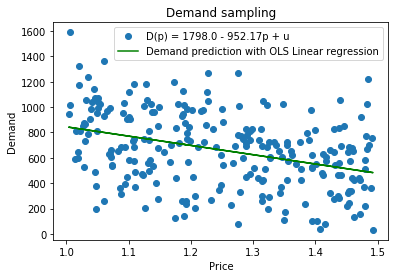

In [26]:
coef1, coef2 = samplingDemand(sampleSize = n, coefVar = cv)
plt.plot(p,D, 'o', label = 'D(p) = ' + str(round(a,0)) + ' - ' + str(round(b,2)) + 'p + u')
plt.plot(p, coef1 + coef2*p, 'g-', label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend()
plt.title('Demand sampling')

### Optimization model to find the ordering quantity as a function of price
Here we use the approach presented in Beutel (2012) that integrates demand estimation and ordering optimization in a single model (instead of sequential steps) to learn about the relationship between ordering quantity and price. The main idea is to predict the ordering quantity by exploring historical data of demand-price with consideration of the overage and underage costs during estimating (i.e. different weights applied to the positive/negative errors in regression).  
  
There is a slight difference in two models below to the base models in Beutel (2012). In her models, Beutel assumes fixed holding cost and penalty cost, representing the overage and underage cost respectively. In other words, these costs are **independent with selling price**. However, here we will define the overage and underage cost as in the traditional newsvendor model, i.e.:     
- overage cost (co) = procurement cost (c)
- underage cost (cu) = selling price - procurement cost (p-c)

Therefore, the underage cost and so the critical fractile **depends on the selling price**. This modification is to match with the model in the second step and is more logical especially when considering the context of price-setting newsvendor, since it causes the trade-off characteristic in price decision. For example, increasing price affects the total cost (expected profit) in both positive way by decreasing underage cost (increasing revenue) per unit and negative way by decreasing demand.


Two following models assume ordering quantity is a linear function of the price: *q = beta0 + beta1 * p*. The decision variables in these models are the coefficients beta0 and beta1, as well as the waste (overage) and shortage (underage) for each demand observation. The objective function is considered as a cost minimization objective or with a service level constraint in each model.

#### The cost model

In [27]:
# Cost model
def costModel(sampleSize, procurementCost):
    
    baseCostModel = gp.Model("Base Cost model")

    #### Variables
    betaC0 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) #~ beta0
    betaC1 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) #~ beta1

    waste = {} # = q - D (overage)
    shortage = {} # = D - q (underage)
    sales = {} # = min(D, q)
    for i in range(sampleSize):
        #overage cost per unit (co) = c
        waste[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost) 
        #underage cost per unit (cu) = p-c 
        shortage[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = p[i] - procurementCost)

        sales[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)

    #### Constraints
    for i in range(sampleSize):
        baseCostModel.addConstr(shortage[i] == D[i] - sales[i]) #shortage = D - min(D, q) >= 0
        baseCostModel.addConstr(waste[i] >= betaC0 + betaC1 * p[i] - D[i]) #waste = max(0, q-D)
        baseCostModel.addConstr(sales[i] <= D[i]) #sales = min(D,q)
        baseCostModel.addConstr(sales[i] <= betaC0 + betaC1 * p[i])
        
    baseCostModel.Params.OutputFlag = 0 #not print Gurobi output to reduce memory
    baseCostModel.optimize()
    obj = baseCostModel.objVal; beta0 = betaC0.x; beta1 = betaC1.x;
    baseCostModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Cost model

Objective: 32516.406238584197
Estimation of a: 1416.725370614948
Estimation of b: -535.3783431087206

Ordering quantity - price function: q =  1417.0 + -535.38 * p


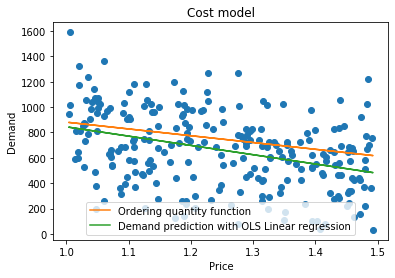

In [28]:
objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: q = ', round(betaC0,0),'+', round(betaC1,2),'* p')


#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

#### The service level model

In [29]:
# Service level model
def SLModel(sampleSize, procurementCost, nonStockOut):
    
    baseSLModel = gp.Model("Base Service level model")

    #### Variables
    betaSL0 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ beta0
    betaSL1 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ beta1

    waste = {}
    sales = {}
    unfulfilled = {} # binary variable: = 1 if D > q (underage, unfulfilled demand existing), = 0 otherwise
    for i in range(sampleSize):
        waste[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = procurementCost)   
        sales[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)
        unfulfilled[i] = baseSLModel.addVar(vtype = GRB.BINARY)

    #### Constraints
    for i in range(sampleSize): #same as Cost model
        baseSLModel.addConstr(waste[i] >= betaSL0 + betaSL1 * p[i] - D[i])
        baseSLModel.addConstr(sales[i] <= D[i])
        baseSLModel.addConstr(sales[i] <= betaSL0 + betaSL1 * p[i])

        #if D < q then unfulfilled must equal to 1
        baseSLModel.addConstr(D[i] - unfulfilled[i]*np.max(D) <= betaSL0 + betaSL1 * p[i])

    #non-stockout (alpha level)    
    baseSLModel.addConstr(sum(unfulfilled[i] for i in range(sampleSize)) <= sampleSize*(1-nonStockOut)) 

    #fillrate (beta level)
    #baseSLModel.addConstr( sum(sales[i] for i in range(sampleSize)) >= fillRate * sum(D[i] for i in range(sampleSize)) )

    baseSLModel.Params.OutputFlag = 0 #not print Gurobi output to reduce memory
    baseSLModel.optimize()
    obj = baseSLModel.objVal; beta0 = betaSL0.x; beta1 = betaSL1.x;
    baseSLModel.dispose()
    
    return obj, beta0, beta1

Example of ordering quantity function with Service level model (alpha level)

Objective: 41720.4784162914
Estimation of a: 1802.8810308446007
Estimation of b: -658.3034296321549

Ordering quantity - price function: q =  1803.0 + -658.3 * p


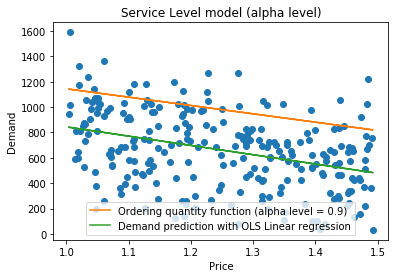

In [30]:
objSL, betaSL0, betaSL1 = SLModel(sampleSize = n, procurementCost = c, nonStockOut = alpha)
print("Objective:",objSL)
print('Estimation of a:', betaSL0)
print('Estimation of b:', betaSL1)

print('\nOrdering quantity - price function: q = ', round(betaSL0,0),'+', round(betaSL1,2),'* p')

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaSL0 + betaSL1*p, label='Ordering quantity function (alpha level = ' +str(alpha)+')' )
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Service Level model (alpha level)')
plt.show()

## PRICE AND QUANTITY-SETTING NEWSVENDOR

**Reference:**   
DeYong, G. D. (2020). *The price-setting newsvendor: review and extensions.* International Journal of Production Research, 58(6), 1776-1804.   
Huber et. al. (2019). *A data-driven newsvendor problem: From data to decision.* European Journal of Operational Research, 278(3), 904-915.

 ### Basic approach

From the previous model, we obtain the ordering quantity function of price: *q = beta0 + beta1 * p*. It means that at a certain selling price p, we can calculate a corresponding ordering quantity q, which also represents the estimated demand level at that selling price. So if the relationship between demand and price is captured completely, the expected profit is:  
$\Pi(p)  = p*q(p) - c*q(p) = beta1*p^2 + (beta0 - beta1*c)*p - beta0*c$  
By taking the first-order derivative, we can find the optimal price p* as $\frac{1}{2*beta1}(-beta0 + beta1*c) $   (1)  and so, the optimal ordering quantity q*.   

Below is the optimization model of this approach (hereinafter called as "Basic approach"). The optimal price from this model is similar to the one calculated from equation (1).

To make the problem logical, the lower bound of price is procurement cost per unit (p >= c) to be profitable and the upper bound is -beta0/beta1 so that the expected demand is non-negative. Additionally, in case of beta1 greater than or equal to 0, the maximization problem is unbounded and the vendor will choose the price as high as possible (i.e. maximum value of price in historical data).   

In [31]:
#Price-setting 
def NV_Price(procurementCost, beta0, beta1, priceUpperBound):
    if beta1 >= 0:
        q = beta0 + beta1*priceUpperBound
        profit = priceUpperBound * q - procurementCost*q
        return profit, priceUpperBound, q
    else:
        pricingNV = gp.Model("Basic pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        pricingNV.addConstr(quantity == beta0 + beta1*price)

        pricingNV.setObjective(price * quantity - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0 #not print output
        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()

        return pricingNV.objVal, price.x, quantity.x

Example with results from Cost model:

In [33]:
objVal, price, quantity = NV_Price(procurementCost = c, beta0 = betaC0, beta1 = betaC1, priceUpperBound = ubp)

print("Objective: ", objVal)
print('Optimal price from LP model:', price)
print('Optimal price from equation (1):', 0.5*(-betaC0+betaC1*c)/betaC1)

Objective:  616.519235296883
Optimal price from LP model: 1.5731067233581113
Optimal price from equation (1): 1.5731067233581113


### Data-driven approach

However, another approach is proposed here to make the solution more data-driven and robust.  
Using estimation error calculated from historical demand and ordering quantity-price function, we can generate the distribution of estimated demand at a certain price and then solve a data-driven quantity-setting newsvendor problem with this given price. In detail, demands at certain price p have the form of d_i(p) = beta0 + beta1 * p + error_i with error_i is the estimation error in each observation. Therefore, with historical data set of size n (observations), we can generate n samples of demands at each price.


In [34]:
#Newsvendor with Price-setting
def DDNV_Price(sampleSize, procurementCost, beta0, beta1, priceUpperBound):
    if beta1 >= 0:
        q = beta0 + beta1*priceUpperBound
        profit = priceUpperBound * q - procurementCost*q
        return profit, priceUpperBound, q
    else:
        M = beta0*2 #big M, demand <= beta0
        error = np.array([(D[i] - beta0 - beta1*p[i])[0] for i in range(sampleSize)]) #estimation errors of all demand observations

        pricingNV = gp.Model("Data-driven pricing NV model")

        #### Variables
        price = pricingNV.addVar(lb = procurementCost, ub = -beta0/beta1, vtype = GRB.CONTINUOUS)
        quantity = pricingNV.addVar()

        sales = {}
        z = {}  # binary variable = 1 if beta0 + beta1*p + error > 0, = 0 otherwise 
                # ==> to ensure non-negativity: d_i(p) = max(0, beta0 + beta1*p + error_i)

        for t in range(sampleSize):
            sales[t] = pricingNV.addVar()
            z[t] = pricingNV.addVar(vtype = GRB.BINARY)

        for t in range(sampleSize):
            pricingNV.addConstr(M*z[t] >= beta0 + beta1*price + error[t] ) #if beta0 + beta1*p + error > 0, z must equal to 1
            pricingNV.addConstr(sales[t] <= 0 + M*z[t] ) #if z = 0 (i.e. beta0 + beta1*p + error <= 0), sales = 0; otherwise, unbounded
            pricingNV.addConstr(sales[t] <= beta0 + beta1*price + error[t] + M*(1-z[t]) ) #if z = 1, sales <= beta0 + beta1*p + error: otherwise, unbounded
            pricingNV.addConstr(sales[t] <= quantity)

        pricingNV.setObjective( price * sum(sales[t] for t in range(sampleSize)) / sampleSize - procurementCost*quantity) #maximize expected profit
        pricingNV.modelSense = 0 #maximization

        pricingNV.Params.OutputFlag = 0

        pricingNV.Params.NonConvex = 2 #enable Quadratic Optimization mode of Gurobi
        pricingNV.optimize()
        
        #if pricingNV.Status != 2: return 0,0,0

        return pricingNV.objVal, price.x, quantity.x

Example run with results from Cost model

In [36]:
objValDD, priceDD, quantityDD = DDNV_Price(sampleSize = n, procurementCost = c, beta0 = betaC0, beta1 = betaC1, priceUpperBound = lbp)

print("Objective: ", objValDD)
print('Optimal price:', priceDD)
print('Optima ordering quantity:', quantityDD)

Objective:  381.2698267184343
Optimal price: 1.4474668590321338
Optima ordering quantity: 680.190012624412


In [143]:
# function to combine two steps into 1 flow

In [38]:
def DDNV_main(sampleSize, procurementCost, priceUpperBound, estimationModel = 'cost', nonStockOut = None):

    if estimationModel == 'service' and nonStockOut is not None:
        (estObjVal, estBeta0, estBeta1) = SLModel(sampleSize, procurementCost, nonStockOut)
    else:                
        (estObjVal, estBeta0, estBeta1) = costModel(sampleSize, procurementCost)
    print('\nOrdering quantity parameters:', estBeta0, estBeta1)

    (optV, optP, optQ) = NV_Price(procurementCost, estBeta0, estBeta1, priceUpperBound)
    print('Basic approach:', optV, optP, optQ)

    (optVDD, optPDD, optQDD) = DDNV_Price(sampleSize, procurementCost, estBeta0, estBeta1, priceUpperBound)
    print('Data-driven approach:', optVDD, optPDD, optQDD,'\n')

        
    return optV, optP, optQ, optVDD, optPDD, optQDD


In [40]:
DDNV_main(sampleSize = n, procurementCost = c, priceUpperBound = lbp, estimationModel = 'cost', nonStockOut = None)


Ordering quantity parameters: 1416.725370614948 -535.3783431087206
Basic approach: 616.519235296883 1.5731067233581113 574.518099530294
Data-driven approach: 381.2698267184343 1.4474668590321338 680.190012624412 



(616.519235296883,
 1.5731067233581113,
 574.518099530294,
 381.2698267184343,
 1.4474668590321338,
 680.190012624412)

# ANALYSIS

## Sensitivity analysis

### 1. Procurement cost's effect       

Here we want to learn about the influence of procurement cost (c) on the optimal price and ordering quantity. To do so, for a certain sampling set, we run the model with different procurement costs from 0.1 to 0.9 (since c < p). Then this test is done for multiple times to get the average optimal price and ordering quantity over all test instances.

In [ ]:
testRep = 50
costSet = [0.1*(i+1) for i in range(9)]
resultCost = pd.DataFrame(index = range(len(costSet)), columns = ['Procurement cost', 
                                                                  'Avg. opt. price (Basic)', 'Avg. opt. price (DD)',
                                                                  'Avg. opt. order qty (Basic)', 'Avg. opt. order qty (DD)' ])
#book-keeping variables
optPrice = np.zeros(shape=(len(costSet),testRep))
optQty = np.zeros(shape=(len(costSet),testRep))
optPriceDD = np.zeros(shape=(len(costSet),testRep))
optQtyDD = np.zeros(shape=(len(costSet),testRep))

for j in range(testRep):
    print('Test run = ', j)
    # in each test run, draw a sampling set 
    samplingDemand(sampleSize=n, coefVar=cv)
    
    for i in range(len(costSet)):
        print('Considering c =', costSet[i])
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=costSet[i], 
                                                             estimationModel = 'cost', nonStockOut = None, priceUpperBound = lbp)
        
        optPrice[i,j] = optP
        optQty[i,j] = optQ
        optPriceDD[i,j] = optPDD
        optQtyDD[i,j] = optQDD    

for i in range(len(costSet)):
    resultCost.iloc[i,:] = [costSet[i], np.mean(optPrice[i,:]), np.mean(optQty[i,:]), 
                            np.mean(optPriceDD[i,:]), np.mean(optQtyDD[i,:])]

Test run =  0
Considering c = 0.1

Ordering quantity parameters: 1394.0549012666904 -635.3611607384256
Basic approach: 696.5645475140497 1.1470570656589238 665.2593925964239
Data-driven approach: 455.2965275901894 0.9678351882566936 765.5360493588307 

Considering c = 0.2

Ordering quantity parameters: 1410.411480502916 -685.8082761874955
Basic approach: 590.968778676272 1.128284091542021 636.6249126327083
Data-driven approach: 393.243604960771 0.9892306349103313 699.6489943118672 

Considering c = 0.30000000000000004

Ordering quantity parameters: 1450.8814975120385 -760.29472003621
Basic approach: 491.65898458953137 1.1041572887964672 611.3965407505877
Data-driven approach: 339.7914648458048 1.0040391238294972 657.4357620646886 

Considering c = 0.4

Ordering quantity parameters: 1386.3699574896489 -745.2450124255616
Basic approach: 397.29747361400035 1.1301437341911267 544.135976259712
Data-driven approach: 276.1779309022611 1.0458545393202507 571.2602487652343 

Considering c = 0.5

In [198]:
resultCost

,Procurement cost,Avg. opt. price (Basic),Avg. opt. order qty (Basic),Avg. opt. price (DD),Avg. opt. order qty (DD)
0,0.1,2.50022,994.001,1.8701,1293.06
1,0.2,1.84606,893.507,1.49656,1122.2
2,0.3,1.78157,804.594,1.52688,1001.56
3,0.4,2.18554,691.726,1.97284,904.653
4,0.5,2.05689,638.247,1.96854,818.805
5,0.6,2.32039,543.016,2.36342,759.506
6,0.7,4.46281,456.116,5.21184,752.976
7,0.8,2.83838,428.51,3.44621,705.306
8,0.9,4.78938,481.961,1.61754,491.817


**Comment:** In general, when the procurement cost increases, the optimal price also increases to cover up the increase in cost, leading to the decrease in optimal ordering quantity. We can see that in general, the increase speed in optimal price in Data-driven approach is slower than that of Basic approach. It is because in Basic approach, the optimal price is calculated from a fixed equation so the change in cost is shown completely; meanwhile, in Data-driven approach, this influence is affected by the stochastic demand.

To generate out-of-sample demand observations, we will randomly draw 100,000 error terms in the same way as we dis previously with sampling set (u ~ N(0,sigma)) and D = a - b * p + u, with . This out-of-sample set will be used to evaluate the performance of the solution, which will be done for a significant number of times to obtain the average performance.

In [147]:
def outOfSampleError(testSize):
    testU = np.random.normal(loc = 0, scale = sigma, size =(testSize,) )
    return testU

In [148]:
def outOfSampleDemand(testU, chosenPrice):
    testD = a - b*chosenPrice + testU
    for i in range(len(testD)):
        if testD[i]<=0: testD[i] = 0
            
    return testD

In [149]:
def testEvaluation(testD, chosenPrice, chosenQty, procurementCost):
    return sum( [chosenPrice * min(testD[i], chosenQty) for i in range(len(testD))] ) / len(testD) - procurementCost*chosenQty   
    

### 2. Sample size's effect       

Here we want to learn about the effect of sample size on performance of solution. To do so, from the same demand sampling set, we take subsets with different sizes and solve the problem with these subsets. The solutions are evaluated by generating out-of-sample demand based on each chosen price solution with same error terms. Then this test is done for multiple times to get the average objective value (i.e. expected profit).

In [20]:
import copy

testRep = 50

# Run the model with different sample sizes: 50, 100, 200, 500 and 700
sampleSizeSet = [50, 100, 200, 500, 700]
resultSize = pd.DataFrame(index = range(len(sampleSizeSet)), columns = ['Sample size','Avg. in-sample profit', 'Avg. out-of-sample profit'])
optValInSample = np.zeros(shape=(len(sampleSizeSet),testRep))
optValOutSample = np.zeros(shape=(len(sampleSizeSet),testRep))
for j in range(testRep):
    print('Test run = ', j)
    samplingDemand(sampleSize=max(sampleSizeSet), coefVar=cv)
    demandPool = copy.deepcopy(D)
    pricePool = copy.deepcopy(p)
    errorPool = copy.deepcopy(u)
    
    testU = outOfSampleError(testSize = 100000)
    
    for i in range(len(sampleSizeSet)):
        print('Considering n =', sampleSizeSet[i])
        if sampleSizeSet[i] != max(sampleSizeSet):
            lowElasticity = True
            while lowElasticity:
                idx = np.random.choice(max(sampleSizeSet), size = sampleSizeSet[i], replace = False)
                for k in range(len(idx)): 
                    D[k] = demandPool[k] 
                    p[k] = pricePool[k] 
                    u[k] = errorPool[k]
                
                reg = linear_model.LinearRegression().fit(p, D)
                coef2 = reg.coef_
                coef1 = reg.intercept_
                Q1 = coef1 + coef2*min(p)
                Q2 = coef1 + coef2*max(p)
                arcElasticity = ( (min(p) + max(p)) / (Q1 + Q2)) * ((Q2 - Q1) / (max(p) - min(p)) )
                if abs(arcElasticity) >= 1: lowElasticity = False

        else:
            D = demandPool; p = pricePool; u = errorPool;
        
        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=sampleSizeSet[i], procurementCost=c, estimationModel = 'cost', nonStockOut = None)
        
        testD = outOfSampleDemand(testU, chosenPrice = optPDD)
        testV = testEvaluation(testD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)
        
        optValInSample[i,j] = optVDD
        optValOutSample[i,j] = testV
        
for i in range(len(sampleSizeSet)):
    resultSize.iloc[i,:] = [sampleSizeSet[i], np.mean(optValInSample[i,:]), np.mean(optValOutSample[i,:])]

Test run =  0
Considering n = 50

Ordering quantity parameters: 960.5832821598278 -237.89800184873937
Basic approach: 744.3823170497974 2.2688973314088345 420.81714061772914
Data-driven approach: 536.945009667093 2.185152049645537 634.5119020128452 

Considering n = 100

Ordering quantity parameters: 1446.6818686169645 -572.5261172393635
Basic approach: 587.9958023087577 1.5134199777580897 580.2094049986414
Data-driven approach: 463.31677369732506 1.4855196898363794 748.0601734474438 

Considering n = 200

Ordering quantity parameters: 1632.7108316678948 -719.6185098083752
Basic approach: 562.8949235057165 1.3844280402839164 636.4507883818537
Data-driven approach: 440.8536877818668 1.3459984717667346 757.0264890989106 

Considering n = 500

Ordering quantity parameters: 1629.7710437392325 -698.661728387335
Basic approach: 586.6669758693768 1.4163520252505475 640.2200897727827
Data-driven approach: 459.95776881267494 1.3887519689528316 804.6630059884315 

Considering n = 700

Ordering q

Data-driven approach: 715.3119772004852 2.0976290961823247 880.152418670828 

Test run =  7
Considering n = 50

Ordering quantity parameters: 1123.369994758177 -448.58831345806726
Basic approach: 450.4895347676996 1.5021168753799763 449.5379190145719
Data-driven approach: 351.19854098565827 1.4525452432740353 539.6246775100972 

Considering n = 100

Ordering quantity parameters: 1195.6822503236276 -511.169363631444
Basic approach: 432.23611448264006 1.4195558609276524 470.04878425395293
Data-driven approach: 329.91475936827885 1.3643625324419129 545.7417736557668 

Considering n = 200

Ordering quantity parameters: 1195.8378751372463 -549.2329022812884
Basic approach: 386.2882706522987 1.3386436975736757 460.61071199830116
Data-driven approach: 277.71351855434847 1.276434542637132 531.1216416448603 

Considering n = 500

Ordering quantity parameters: 1251.165241803987 -582.0603136340475
Basic approach: 395.9466741802785 1.324772847844956 480.0675424934818
Data-driven approach: 291.3664

Data-driven approach: 353.356821955577 1.4268213751230305 620.0632819141075 

Considering n = 700

Ordering quantity parameters: 1246.1658243210936 -512.5755397932642
Basic approach: 477.9093453358902 1.4655923640286335 494.9390272122309
Data-driven approach: 354.1301624955163 1.4313165171033897 625.2159413002307 

Test run =  14
Considering n = 50

Ordering quantity parameters: 1137.4978187127379 -585.0068991411463
Basic approach: 305.1312236360876 1.2222088922222185 422.4971845710823
Data-driven approach: 227.32248872398932 1.170629333645689 465.1835703450708 

Considering n = 100

Ordering quantity parameters: 1205.3088747905329 -613.3471595437073
Basic approach: 329.1551044493598 1.2325666068847605 449.3176475093396
Data-driven approach: 259.2328311901954 1.202493228677983 517.3639716148575 

Considering n = 200

Ordering quantity parameters: 1431.2991345292814 -801.3694416387616
Basic approach: 331.35967462601405 1.1430332629120123 515.3072068549503
Data-driven approach: 268.87506

Data-driven approach: 406.57606601995883 1.4554201329225276 709.0483380214116 

Considering n = 700

Ordering quantity parameters: 1517.0426014101495 -647.9504631312266
Basic approach: 549.1969795457505 1.4206470538496316 596.5336849222681
Data-driven approach: 400.1630982799563 1.3715994881818754 738.3879681906841 

Test run =  21
Considering n = 50

Ordering quantity parameters: 1063.1574278536295 -408.26334578245644
Basic approach: 451.86841735354324 1.5520485904949868 429.5128774812008
Data-driven approach: 387.7307981468645 1.5671148728945004 592.4748785994818 

Considering n = 100

Ordering quantity parameters: 1149.2481376365545 -481.01327110940355
Basic approach: 429.2039155704273 1.4446116735884869 454.3707510409265
Data-driven approach: 363.6624486801926 1.4517054991426646 602.1553354482585 

Considering n = 200

Ordering quantity parameters: 1447.4679443022699 -759.1228525614159
Basic approach: 375.5730470321573 1.2033818797696938 533.953259010781
Data-driven approach: 298.3

Data-driven approach: 299.8869304863304 1.3966454403775166 591.446596101878 

Considering n = 500

Ordering quantity parameters: 1314.2946902867395 -547.7663099513773
Basic approach: 494.03191796533764 1.4496855834410514 520.2057676555254
Data-driven approach: 362.79516113843613 1.4001729917932917 647.1901048867683 

Considering n = 700

Ordering quantity parameters: 1402.2071432097673 -612.1494756072321
Basic approach: 490.69152962584036 1.3953143383148567 548.0662027030756
Data-driven approach: 364.88033956416 1.3504661361142873 669.6628166746283 

Test run =  28
Considering n = 50

Ordering quantity parameters: 1775.9108843000308 -841.8732978037292
Basic approach: 545.1993736416356 1.3047376243747186 677.4871176990832
Data-driven approach: 344.7157014208141 1.2154753236240394 773.5151573230046 

Considering n = 100

Ordering quantity parameters: 1437.0272309248398 -494.00656313847264
Basic approach: 716.6691222900574 1.7044616794109608 595.011974677802
Data-driven approach: 504.8317

Data-driven approach: 582.3117267199998 1.6270710358802685 910.1763653412758 

Considering n = 200

Ordering quantity parameters: 1400.9716273234976 -386.1266699077902
Basic approach: 944.6656735234571 2.0641347600491566 603.9541461848012
Data-driven approach: 725.3126635280655 2.0680406541717566 887.6164054242832 

Considering n = 500

Ordering quantity parameters: 1300.4738398115894 -308.97286726570115
Basic approach: 1062.6233516411917 2.3545113949977474 572.9937030893695
Data-driven approach: 831.9360235263327 2.3921411390252296 899.9452588046244 

Considering n = 700

Ordering quantity parameters: 1442.6785000015977 -407.3428513339687
Basic approach: 942.1661170829054 2.020840577264466 619.5035371673067
Data-driven approach: 745.8157684109418 2.036591465422352 902.4331785087045 

Test run =  35
Considering n = 50

Ordering quantity parameters: 2019.573937613607 -871.8140921668801
Basic approach: 719.1902625407286 1.4082595164262532 791.8334457650835
Data-driven approach: 535.17323

Data-driven approach: 296.37935243819527 1.1585943421979557 592.3933223429491 

Considering n = 200

Ordering quantity parameters: 1467.3536284077686 -801.2532065730383
Basic approach: 355.0396231769417 1.1656616262939175 533.3635125606246
Data-driven approach: 291.492152853673 1.1455495270030287 601.9764627222821 

Considering n = 500

Ordering quantity parameters: 1485.8772634054028 -824.909057564878
Basic approach: 349.2010290827786 1.1506309542725202 536.7113673114819
Data-driven approach: 281.9136941984409 1.12321103909357 591.7320392817617 

Considering n = 700

Ordering quantity parameters: 1455.8842567543686 -804.1676273650096
Basic approach: 345.23130999975126 1.1552119279688104 526.9002215359319
Data-driven approach: 277.0947291895588 1.1263939229382216 580.8013461486278 

Test run =  42
Considering n = 50

Ordering quantity parameters: 759.0143389536341 -299.81695820500204
Basic approach: 309.36371205136055 1.5157962102908344 304.55292992556656
Data-driven approach: 179.6863

Data-driven approach: 428.33146005888506 1.222966055743239 876.8322587309738 

Considering n = 100

Ordering quantity parameters: 1995.0005010924422 -980.1252503777197
Basic approach: 577.6909658883815 1.2677273263410012 752.4689379517913
Data-driven approach: 402.96199760395535 1.210361850505987 881.0225032837018 

Considering n = 200

Ordering quantity parameters: 1949.9940761852506 -953.045456138852
Basic approach: 569.521054775888 1.2730330901977198 736.7356740579123
Data-driven approach: 410.73849318934447 1.2212807199394273 856.9117698824691 

Considering n = 500

Ordering quantity parameters: 1498.1625334723947 -589.8337227072179
Basic approach: 613.6475805534978 1.5199871809601955 601.6228360593927
Data-driven approach: 443.8512402478056 1.4660475968851792 769.6764151534204 

Considering n = 700

Ordering quantity parameters: 1533.0977302746844 -619.9277799675976
Basic approach: 603.3188218081328 1.4865131712236033 611.5669201454427
Data-driven approach: 448.5342804416988 1.439

In [21]:
resultSize

,Sample size,Avg. in-sample profit,Avg. out-of-sample profit
0,50,807.494,200.768
1,100,491.703,218.931
2,200,521.959,201.168
3,500,494.639,193.956
4,700,480.954,215.021


**Comment:** As expected, the more historical data we have, the higher the out-of-sample profit is, which means better solution we have. With more data, the relationship between demand and price is capture more correctly and so the estimated demand is nearer to the true demand. 

In [201]:
testRep = 50

resultOLS = pd.DataFrame(index = range(testRep), columns = ['Avg. in-sample profit (OLS)', 'Avg. in-sample profit (Integrated)', 'Avg. out-of-sample profit (OLS)', 'Avg. out-of-sample profit (Integrated)'])

for i in range(testRep):
    print('Test run = ', i)
    coef1, coef2 = samplingDemand(sampleSize=n, coefVar=cv)
    coef2=coef2[0]
    testU = outOfSampleError(testSize = 100000)

    optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=c, estimationModel = 'cost', nonStockOut = None)

    (optV_OLS, optP_OLS, optQ_OLS) = NV_Price(c, coef1, coef2)
    
    (optVDD_OLS, optPDD_OLS, optQDD_OLS) = DDNV_Price(n, c, coef1, coef2)
    
    testD = outOfSampleDemand(testU, chosenPrice = optP)
    testV = testEvaluation(testD, chosenPrice = optP, chosenQty = optQ, procurementCost = c)

    #Data-driven approach
    testD_OLS = outOfSampleDemand(testU, chosenPrice = optP_OLS)
    testV_OLS = testEvaluation(testD_OLS, chosenPrice = optP_OLS, chosenQty = optQ_OLS, procurementCost = c)

    resultOLS.iloc[i,:] = [optV_OLS, optV, testV_OLS, testV]
print(resultOLS)

Test run =  0

Ordering quantity parameters: 1722.2925867375093 -770.6773075763081
Basic approach: 558.0026587527445 1.3838713492443102 655.7743412699115
Data-driven approach: 353.5259852764853 1.2940700421748506 738.7282523972875 

Test run =  1

Ordering quantity parameters: 1126.3882533767774 -481.9449766974421
Basic approach: 392.2023768827007 1.4350683639444095 434.7642641563526
Data-driven approach: 233.3749736018342 1.3291765077105824 503.32871932010084 

Test run =  2

Ordering quantity parameters: 1325.726790035044 -658.522703667152
Basic approach: 360.71341122496784 1.2730739767286667 487.3786729113894
Data-driven approach: 233.4759788702363 1.1945059380004628 532.9869112582418 

Test run =  3

Ordering quantity parameters: 1717.0740204539086 -809.4324670924155
Basic approach: 510.5305936455714 1.3271478160324306 642.8374895264672
Data-driven approach: 333.50912490175375 1.242258404673566 712.2489447826277 

Test run =  4

Ordering quantity parameters: 1911.085188055341 -916.

Data-driven approach: 352.4556606413852 1.3145902218386298 740.5802174673017 

Test run =  36

Ordering quantity parameters: 1267.9597533036863 -636.6518009321303
Basic approach: 338.6406627752266 1.2622855798818484 464.3233655812491
Data-driven approach: 216.78175243944466 1.1817272538454668 511.2149648420743 

Test run =  37

Ordering quantity parameters: 1253.267403950719 -686.2639709342142
Basic approach: 286.94462851572086 1.1795912627434426 443.7564199011002
Data-driven approach: 197.48364393285115 1.1193775734969105 468.4941458050373 

Test run =  38

Ordering quantity parameters: 1288.9479685608621 -719.8154687378777
Basic approach: 284.6525233619085 1.161814641284764 452.65581795794014
Data-driven approach: 199.93458556477 1.1104260986079675 485.50409199007345 

Test run =  39

Ordering quantity parameters: 1607.6607770590904 -795.3521625415995
Basic approach: 440.4659062382492 1.277142130835542 591.8830214260557
Data-driven approach: 290.5805200118135 1.1966530943699925 632.4

In [202]:
testRep = 50

resultOLS1 = pd.DataFrame(index = range(testRep), columns = ['Avg. in-sample profit (OLS)', 'Avg. in-sample profit (Integrated)', 'Avg. out-of-sample profit (OLS)', 'Avg. out-of-sample profit (Integrated)'])

for i in range(testRep):
    print('Test run = ', i)
    coef1, coef2 = samplingDemand(sampleSize=n, coefVar=cv)
    coef2=coef2[0]
    testU = outOfSampleError(testSize = 100000)

    optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=n, procurementCost=c, estimationModel = 'cost', nonStockOut = None)

    (optV_OLS, optP_OLS, optQ_OLS) = NV_Price(c, coef1, coef2)
    
    (optVDD_OLS, optPDD_OLS, optQDD_OLS) = DDNV_Price(n, c, coef1, coef2)
    
    testD = outOfSampleDemand(testU, chosenPrice = optPDD)
    testV = testEvaluation(testD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)

    #Data-driven approach
    testD_OLS = outOfSampleDemand(testU, chosenPrice = optPDD_OLS)
    testV_OLS = testEvaluation(testD_OLS, chosenPrice = optPDD_OLS, chosenQty = optQDD_OLS, procurementCost = c)

    resultOLS1.iloc[i,:] = [optV_OLS, optV, testV_OLS, testV]
print(resultOLS1)

Test run =  0

Ordering quantity parameters: 1422.0180299989113 -545.4785100515494
Basic approach: 586.5644813549543 1.5699416774756496 565.6485829016638
Data-driven approach: 345.3870555088049 1.455301690104344 687.1211223509747 

Test run =  1

Ordering quantity parameters: 815.3443242895765 -169.1057993848629
Basic approach: 777.530286738767 2.6772345244157214 362.60843989750276
Data-driven approach: 543.0967992422552 2.6593691650407254 561.9974116509245 

Test run =  2

Ordering quantity parameters: 1232.9403250820997 -732.8022597579442
Basic approach: 242.0872237940509 1.1077327744586087 421.1912447508942
Data-driven approach: 175.7927076501647 1.0581553951072893 435.3180440132644 

Test run =  3

Ordering quantity parameters: 1277.0900091465596 -484.66245343755065
Basic approach: 535.3812142397403 1.583987002565824 509.3909822698155
Data-driven approach: 339.971458341565 1.483300182284425 612.6981569995961 

Test run =  4

Ordering quantity parameters: 1247.4190335818514 -321.461

Test run =  36

Ordering quantity parameters: 1926.3658481132663 -815.0208765646447
Basic approach: 682.8135919534475 1.448271684277645 745.9941904895456
Data-driven approach: 439.27649104312445 1.3555327133226283 852.5600784848695 

Test run =  37

Ordering quantity parameters: 1603.0217904617796 -659.761844145655
Basic approach: 593.3890278858341 1.4813312336257123 625.6959639743216
Data-driven approach: 365.6500290245198 1.3820065055058466 735.8636640325307 

Test run =  38

Ordering quantity parameters: 1604.2068337356127 -564.297430256764
Basic approach: 752.7049724240959 1.6879019985697647 651.7280734174383
Data-driven approach: 472.46043380807737 1.5994455693983862 811.1301068724689 

Test run =  39

Ordering quantity parameters: 1319.6118219477378 -350.43569641466496
Basic approach: 915.5251776983529 2.1492983456525163 566.4209593861109
Data-driven approach: 609.9965393501179 2.098535886428197 820.0944378968817 

Test run =  40

Ordering quantity parameters: 1297.08630185064 -3

In [208]:
np.mean(resultOLS1.iloc[:,3])

213.04683000929242

## Basic approach vs Data-driven approach in Price and Quantity-setting Newsvendor

Here we want to compare the performance of Basic approach with Data-driven approach to solve the Price and Quantity-setting Newsvendor. In basic approach, the vendor takes the optimal price as given from the ordering quantity function, while in Data-driven approach, the vendor use the historical data to make the solution more robust.

For a certain sampling set, we runs both approaches to obtain the solution of optimal price and ordering quantity. Two solutions are evaluated with the same out-of-sample demand set to get the profit of each solution when dealing with unknown demand. Then this test is done for multiple times to get the average performance of each solution.

In [159]:
testRep = 50
results = pd.DataFrame(index = range(9), columns = ["Sample size", 'cv', 'Avg Out-of-sample profit (Basic)', 'Avg Out-of-sample profit (DD)', 
                                  'Std. Out-of-sample profit (Basic)', 'Std. Out-of-sample profit (DD)'])
idx=0
for i in [100,200,500]: #n = 100
    for k in [0.3, 0.5, 0.8]: #cv = 0.8
        print(i, k)
        resultDD = pd.DataFrame(index = range(testRep), columns = ['Out-of-sample profit (Basic)', 'Out-of-sample profit (Data-driven)'])

        for j in range(testRep):
            print('Test run = ', j)
            samplingDemand(sampleSize=i, coefVar=k)
            testU = outOfSampleError(testSize = 100000)

            optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize=i, procurementCost=c, estimationModel = 'cost', nonStockOut = 0.8)

            #Basic approach
            testD = outOfSampleDemand(testU, chosenPrice = optP)
            testV = testEvaluation(testD, chosenPrice = optP, chosenQty = optQ, procurementCost = c)

            #Data-driven approach
            testDDD = outOfSampleDemand(testU, chosenPrice = optPDD)
            testVDD = testEvaluation(testDDD, chosenPrice = optPDD, chosenQty = optQDD, procurementCost = c)

            resultDD.iloc[j,:] = [testV, testVDD]

        print(resultDD)
        print('\n\nOut-of-sample profit from Basic approach')
        print('Average:', np.mean(resultDD.iloc[:,0]) )
        print('Variance', np.std(resultDD.iloc[:,0]) )
        print('Out-of-sample profit from Data-driven approach')
        print('Average:', np.mean(resultDD.iloc[:,1]) )
        print('Variance', np.std(resultDD.iloc[:,1]) )
        
        results.iloc[idx,:] = [i, k, np.mean(resultDD.iloc[:,0]), np.mean(resultDD.iloc[:,1]), 
                               np.std(resultDD.iloc[:,0]), np.std(resultDD.iloc[:,1])]
        idx+=1
        
print(results)

100 0.3
Test run =  0

Ordering quantity parameters: 1521.194161129219 -942.7917367467345
Basic approach: 292.23751453210815 1.0567498376568096 524.8991463779258
Data-driven approach: 254.33501403460787 1.0347511383857224 533.474454904276 

Test run =  1

Ordering quantity parameters: 1707.5789706158566 -501.4031169976059
Basic approach: 1058.276126525864 1.9528005139266116 728.4387060585269
Data-driven approach: 745.2141408924665 1.825031863693634 866.5341327662377 

Test run =  2

Ordering quantity parameters: 1890.591708762878 -852.6677597500143
Basic approach: 628.6302504530063 1.358633278990848 732.1289144439354
Data-driven approach: 503.7578395894836 1.3032484005758787 780.0511875542027 

Test run =  3

Ordering quantity parameters: 1228.8155612123744 -509.57031340162604
Basic approach: 465.45844801068455 1.4557369992861648 487.01520225578076
Data-driven approach: 339.70579289115176 1.3712689421706086 541.4588204520747 

Test run =  4

Ordering quantity parameters: 1417.588502469

Data-driven approach: 382.09704400323585 1.2904824859785975 658.3723045785126 

Test run =  36

Ordering quantity parameters: 1653.1373207594108 -873.8833729743916
Basic approach: 423.14909133364995 1.1958569483549693 608.0978171361076
Data-driven approach: 310.4269173279221 1.1391112550647087 650.473487207702 

Test run =  37

Ordering quantity parameters: 1980.5522985568227 -751.9441981979865
Basic approach: 856.0068761293296 1.5669543054545545 802.2900997289148
Data-driven approach: 643.9703567693101 1.4810736593776594 898.1450574427531 

Test run =  38

Ordering quantity parameters: 2286.537970949337 -1128.7224393977892
Basic approach: 656.9136616372064 1.2628876201705 861.0883756252209
Data-driven approach: 514.5383717419154 1.2120273337213314 918.4955222145978 

Test run =  39

Ordering quantity parameters: 1380.9522887912735 -576.4918945956398
Basic approach: 517.7900851396631 1.447720472514097 546.3531707467268
Data-driven approach: 379.14726384715544 1.3640192395588666 605.695

Data-driven approach: 268.00053595878273 1.1432256697358933 606.6439769920054 

Test run =  6

Ordering quantity parameters: 1232.1083112686297 -571.559366700855
Basic approach: 391.7081602505947 1.3278480618562722 473.16431395910126
Data-driven approach: 268.05589815423 1.2503617706543835 518.6540120281675 

Test run =  7

Ordering quantity parameters: 1307.0432286749917 -588.8872543220748
Basic approach: 435.2946788458718 1.3597567650531475 506.29980075697716
Data-driven approach: 280.9609293031583 1.2595712980211242 565.2977453604403 

Test run =  8

Ordering quantity parameters: 1200.8224088432635 -448.54692724885695
Basic approach: 531.5206639900402 1.5885694292996893 488.2744726094174
Data-driven approach: 332.4347969262692 1.4573300580793795 567.679667179354 

Test run =  9

Ordering quantity parameters: 1138.2782903996713 21.65339461007373
Basic approach: 1170.758382314782 1.5 1170.7583823147818
Data-driven approach: 1170.758382314782 1.5 1170.7583823147818 

Test run =  10

Or


Ordering quantity parameters: 1652.6493726782342 -631.0979826194078
Basic approach: 708.2249821316767 1.559344521922586 668.5501906842653
Data-driven approach: 499.8974633749291 1.4809820277696417 781.7892413968908 

Test run =  42

Ordering quantity parameters: 1372.414866707019 -355.23092258105123
Basic approach: 1004.6602987229317 2.18172212702553 597.3997027082465
Data-driven approach: 601.4633103941378 2.028561084705614 824.9180392862804 

Test run =  43

Ordering quantity parameters: 1026.9182812832548 -227.09250140015533
Basic approach: 918.4015996873707 2.511013188352137 456.6860152915887
Data-driven approach: 631.9628052806041 2.350382748695944 686.1052552867937 

Test run =  44

Ordering quantity parameters: 1382.3037579458567 -562.6362787596007
Basic approach: 538.6114342651591 1.4784168388441918 550.4928092830282
Data-driven approach: 330.66682566543335 1.3577427987163722 630.6513459614407 

Test run =  45

Ordering quantity parameters: 2281.877438601318 -1095.412860580788


Ordering quantity parameters: 1214.9714833887865 -162.50852153487017
Basic approach: 1977.3036034182292 3.9881777641983063 566.8586113106757
Data-driven approach: 1409.655170825499 4.319676239220242 1014.2785801994302 

Test run =  12

Ordering quantity parameters: 2342.6853975486556 -1105.899665066454
Basic approach: 724.1057877724868 1.3091762849516202 894.8677825077144
Data-driven approach: 403.1110576274629 1.2122076947945004 1002.0597716679304 

Test run =  13

Ordering quantity parameters: 943.5663917996786 -96.28678953854502
Basic approach: 2081.755834454189 5.149770759424661 447.7114985152031
Data-driven approach: 1555.929466800707 5.623103073933432 960.8537374966638 

Test run =  14

Ordering quantity parameters: 1769.3588791341517 -479.09373745211496
Basic approach: 1221.2248899531735 2.0965685739745217 764.9060052040471
Data-driven approach: 712.0892582049411 2.162417777573533 1214.5854681451701 

Test run =  15

Ordering quantity parameters: 1396.0973576729737 -612.3518500

Data-driven approach: 445.44323466425783 2.0532334501163447 744.166433058009 

Test run =  47

Ordering quantity parameters: 1250.4087779902995 -736.3238720054006
Basic approach: 264.27212256381347 1.099088849031047 441.12342099379964
Data-driven approach: 193.04768236272434 1.0482029690654724 459.69377088409647 

Test run =  48

Ordering quantity parameters: 1659.6160965196823 -468.88122529812864
Basic approach: 1082.9635791742355 2.019761729598417 712.5877419353088
Data-driven approach: 596.7624016160675 1.9577866810274 1049.8729785162504 

Test run =  49

Ordering quantity parameters: 1888.228024907368 -910.1951674250056
Basic approach: 564.127050709873 1.287265463762719 716.5652205974327
Data-driven approach: 309.44038378402905 1.1695692017688621 806.7919752247158 

   Out-of-sample profit (Basic) Out-of-sample profit (Data-driven)
0                        187.94                            236.225
1                       493.979                            459.234
2                 

Test run =  17

Ordering quantity parameters: 1534.7686792699462 -714.1442574275753
Basic approach: 485.53536304691687 1.3245508791167404 588.8482752780795
Data-driven approach: 346.01252853830334 1.249159495260986 644.1359232333575 

Test run =  18

Ordering quantity parameters: 1459.8517394252824 -826.9466803750747
Basic approach: 331.00917519093645 1.1326758569023723 523.1891996188725
Data-driven approach: 266.5815589055238 1.0940737626532369 541.1435928866551 

Test run =  19

Ordering quantity parameters: 1712.137939077966 -609.8244190167098
Basic approach: 811.8255813516637 1.6537958186707602 703.6128647848055
Data-driven approach: 599.635305923033 1.5754661958350007 847.7261271539519 

Test run =  20

Ordering quantity parameters: 1512.5578451051617 -631.6217108126234
Basic approach: 566.8754465036653 1.4473605555445168 598.373494849425
Data-driven approach: 426.189365046397 1.3752874160519484 668.695452278635 

Test run =  21

Ordering quantity parameters: 1726.16072811786 -726

Out-of-sample profit from Data-driven approach
Average: 387.56219050617057
Variance 89.90915006300048
200 0.5
Test run =  0

Ordering quantity parameters: 1481.8314942795687 -756.6322371234564
Basic approach: 402.3573556273787 1.2292283632489376 551.7576878589203
Data-driven approach: 259.40336233536016 1.147533473610628 595.7216203770784 

Test run =  1

Ordering quantity parameters: 1271.5120730012136 -558.5077110583551
Basic approach: 440.717446978055 1.3883120123728792 496.12910873601794
Data-driven approach: 279.27243063354763 1.2892640358174365 578.1307887299697 

Test run =  2

Ordering quantity parameters: 1961.4892529018177 -906.7197969748544
Basic approach: 627.1105354804123 1.3316402484240757 754.0646772071952
Data-driven approach: 416.5453519162029 1.2447282259013377 833.3000915891406 

Test run =  3

Ordering quantity parameters: 1647.120368448088 -605.8213876632484
Basic approach: 745.6404173439653 1.6094108775205995 672.1048373082318
Data-driven approach: 473.33662505783


Ordering quantity parameters: 1368.784685228391 -667.8569908394933
Basic approach: 400.88198082613246 1.2747588211271357 517.4280949043223
Data-driven approach: 260.1394479395869 1.1941264658280184 568.8791965881882 

Test run =  36

Ordering quantity parameters: 1354.69131571872 -460.7340977944089
Basic approach: 685.9189839731667 1.7201444088941915 562.1621334107579
Data-driven approach: 414.49454389862626 1.5955232377611825 709.206697898044 

Test run =  37

Ordering quantity parameters: 1698.7504317091398 -380.96400277939057
Basic approach: 1492.840295475121 2.4795419243230388 754.1342151597222
Data-driven approach: 876.2362817901115 2.371419623279785 1078.1152822773215 

Test run =  38

Ordering quantity parameters: 1058.0637487926037 -427.53547593710505
Basic approach: 416.8284236126595 1.4873987754740803 422.14800541202555
Data-driven approach: 247.12193175736286 1.3598723995356903 490.3872471300913 

Test run =  39

Ordering quantity parameters: 1721.1201586054028 -422.7808598

Data-driven approach: 383.64660971822906 1.666282734113002 752.9607185822666 

Test run =  5

Ordering quantity parameters: 1906.774413438084 -708.3067820277273
Basic approach: 850.8432011523735 1.5960088635459666 776.3105112121103
Data-driven approach: 466.5628149871122 1.465079609824929 948.7901293769401 

Test run =  6

Ordering quantity parameters: 2185.287901248726 -783.0888773074397
Basic approach: 1027.187239801367 1.6453000512295517 896.871731297503
Data-driven approach: 530.0946924538857 1.521351164583846 1158.1202266083178 

Test run =  7

Ordering quantity parameters: 1104.5284935400514 -229.28647758273044
Basic approach: 1068.3935964074863 2.6586210952879217 494.94262737434315
Data-driven approach: 606.417520447472 2.693027375728824 847.0950243665503 

Test run =  8

Ordering quantity parameters: 1457.7267408963482 -462.5436259885222
Basic approach: 812.9999018798712 1.8257721639564015 613.2274639510437
Data-driven approach: 462.87532740717523 1.7062878672903197 791.0667697


Ordering quantity parameters: 1053.2970413137898 -479.52126713481584
Basic approach: 345.05325002760134 1.3482797985242003 406.76820387319106
Data-driven approach: 188.77899724232157 1.227482136514798 463.9062624292835 

Test run =  41

Ordering quantity parameters: 1099.6454842616458 -361.8655218759523
Basic approach: 583.112383587437 1.769411794968691 459.35636166183485
Data-driven approach: 315.7935318321755 1.7164032036599166 623.4524212802777 

Test run =  42

Ordering quantity parameters: 1478.070007235261 -620.7341922306787
Basic approach: 549.1602145106345 1.440582076624174 583.8514555599609
Data-driven approach: 311.7981902970069 1.3284894406979189 688.4659882628979 

Test run =  43

Ordering quantity parameters: 1228.617651606497 -408.0462691701159
Basic approach: 643.1831409986089 1.7554881571460739 512.2972585107194
Data-driven approach: 353.72311983522945 1.650847271330142 695.8613368119292 

Test run =  44

Ordering quantity parameters: 1531.1317314846297 -388.6723836741

Data-driven approach: 275.83980153791146 1.1222467666924434 540.5903232773367 

Test run =  10

Ordering quantity parameters: 1692.7221720672042 -863.7968465997571
Basic approach: 460.08402661843513 1.229814975436888 630.4118743836625
Data-driven approach: 345.6589625460557 1.172210912443719 671.1413082363895 

Test run =  11

Ordering quantity parameters: 1740.2077498181234 -917.8749378124106
Basic approach: 447.1343167568914 1.197954714814196 640.6351404559591
Data-driven approach: 347.84349264530425 1.146095356258369 662.700461490641 

Test run =  12

Ordering quantity parameters: 1574.3727541037822 -487.6267030967008
Basic approach: 907.6555449515565 1.8643217179305804 665.2797012777158
Data-driven approach: 666.4960136366159 1.7497492826414134 793.0995626260744 

Test run =  13

Ordering quantity parameters: 1341.67997818319 -506.11378747387573
Basic approach: 585.3921832007213 1.5754726618689912 544.3115422231263
Data-driven approach: 431.9548663158952 1.4915611307679146 615.5143


Ordering quantity parameters: 1682.6912068153745 -623.585771856143
Basic approach: 753.4497622586804 1.5992059013844528 685.4491604436514
Data-driven approach: 530.1751672674773 1.4992201911812442 790.8657981891675 

Test run =  46

Ordering quantity parameters: 1486.7287788464835 -813.3504308116999
Basic approach: 358.55261634787047 1.1639533972845946 540.0267817203168
Data-driven approach: 280.952570956134 1.1197606617702673 566.8869296025736 

Test run =  47

Ordering quantity parameters: 1426.1587481868603 -643.4272991899497
Basic approach: 473.94592106183535 1.3582516626061245 552.2225492959427
Data-driven approach: 344.9403305165495 1.2843501114314149 605.9257794745494 

Test run =  48

Ordering quantity parameters: 1628.1821208341137 -706.5811630825706
Basic approach: 575.0749248216586 1.4021550572696526 637.4457696464142
Data-driven approach: 427.4417812376926 1.3301460893055905 705.8565440119772 

Test run =  49

Ordering quantity parameters: 1427.0032080036656 -760.515755473

Data-driven approach: 362.56582606082526 1.3134865019508164 689.0880105857741 

Test run =  15

Ordering quantity parameters: 1454.3305613677246 -827.1507244695356
Basic approach: 327.38029251468504 1.1291206477515987 520.3775995664785
Data-driven approach: 234.70672274103526 1.0714743626166765 543.532079608099 

Test run =  16

Ordering quantity parameters: 1164.8085926511208 -221.29617877982596
Basic approach: 1255.3926289680112 2.8817865023101525 527.0802516306039
Data-driven approach: 855.7661199071608 2.8595072148108502 854.0982770243182 

Test run =  17

Ordering quantity parameters: 1383.7516454594927 -696.4357104930946
Basic approach: 384.93511120845267 1.2434525359704491 517.7668951064727
Data-driven approach: 253.97902002003661 1.16316128561741 567.319859666517 

Test run =  18

Ordering quantity parameters: 1667.259323266126 -762.6089435832104
Basic approach: 542.1126692603558 1.3431286193893204 642.9774257372605
Data-driven approach: 342.3026952870087 1.2462746009394554 719

   Out-of-sample profit (Basic) Out-of-sample profit (Data-driven)
0                        235.51                            248.401
1                       346.151                            384.031
2                       -1.2051                           -73.9054
3                       212.667                            237.292
4                        46.674                            79.4648
5                       199.378                            230.631
6                       17.8762                           -12.7909
7                       212.261                            223.321
8                       342.637                            375.381
9                       176.714                            200.645
10                      222.701                            261.732
11                      243.268                            302.559
12                      163.324                            211.869
13                      214.289                            256

Data-driven approach: 439.7472532066721 1.8624007791932828 748.5011052564919 

Test run =  20

Ordering quantity parameters: 1470.4589537312124 -714.7973426552301
Basic approach: 433.3057491729999 1.278584513387358 556.5301412017985
Data-driven approach: 248.7310309154542 1.1686634522907404 608.5598392920506 

Test run =  21

Ordering quantity parameters: 1287.0154198816417 -401.30326534437137
Basic approach: 735.2209538759398 1.8535446643789606 543.181893604728
Data-driven approach: 407.1328650166101 1.7959103196113142 732.5815969317753 

Test run =  22

Ordering quantity parameters: 1052.0329149998258 -117.87546827640274
Basic approach: 2091.6948468403575 4.712476079131853 496.5475904308123
Data-driven approach: 1510.4798860330914 5.0789371411720134 1080.6083750200685 

Test run =  23

Ordering quantity parameters: 1205.6371495698522 -543.2595089010549
Basic approach: 401.45170026672884 1.359632808828973 467.0036975596624
Data-driven approach: 221.69591567139724 1.244943636910362 537

  Sample size   cv Avg Out-of-sample profit (Basic)  \
0         100  0.3                          391.208   
1         100  0.5                          269.785   
2         100  0.8                          203.842   
3         200  0.3                          371.222   
4         200  0.5                          226.495   
5         200  0.8                          116.324   
6         500  0.3                          364.498   
7         500  0.5                          182.135   
8         500  0.8                          75.3998   

  Avg Out-of-sample profit (DD) Std. Out-of-sample profit (Basic)  \
0                       405.012                           142.077   
1                       275.401                           191.245   
2                       172.604                           220.466   
3                       387.562                            89.081   
4                       247.074                           163.074   
5                       101.949    

In [160]:
results

,Sample size,cv,Avg Out-of-sample profit (Basic),Avg Out-of-sample profit (DD),Std. Out-of-sample profit (Basic),Std. Out-of-sample profit (DD)
0,100,0.3,391.208,405.012,142.077,140.091
1,100,0.5,269.785,275.401,191.245,227.401
2,100,0.8,203.842,172.604,220.466,285.818
3,200,0.3,371.222,387.562,89.081,89.9092
4,200,0.5,226.495,247.074,163.074,177.276
5,200,0.8,116.324,101.949,157.398,203.372
6,500,0.3,364.498,384.493,84.0893,86.9099
7,500,0.5,182.135,194.698,144.382,181.623
8,500,0.8,75.3998,57.979,113.838,178.813


Data source: https://www.dunnhumby.com/careers/engineering/sourcefiles  
Breakfast at the Frat contains sales and promotion information on the top five products from each of the top three brands within four selected categories (mouthwash, pretzels, frozen pizza, and boxed cereal), gathered from a sample of stores over 156 weeks.

In [161]:
data = pd.read_excel('dunnhumby - Breakfast at the Frat.xlsx', sheet_name = 'dh Transaction Data', skiprows = range(1), header = 0)

In [162]:
test = data.loc[((data['STORE_NUM'] == 15547) | (data['STORE_NUM'] == 21213) | (data['STORE_NUM'] == 26981)), ['WEEK_END_DATE', 'UPC', 'UNITS', 'PRICE', 'BASE_PRICE']]

In [163]:
train = test.loc[test['WEEK_END_DATE']<'2011-01-01']

Objective: 3082.327136752137
Estimation of a: 123.53333333333333
Estimation of b: -46.666666666666664

Ordering quantity - price function: D =  124.0 + -46.67 * p


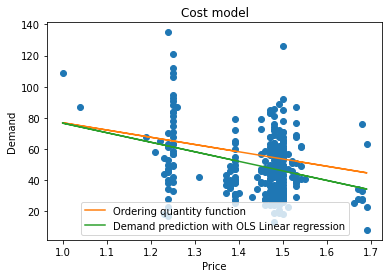

In [166]:
D = np.array(train.loc[train['UPC'] == 1111009477, 'UNITS'])
p = np.array(train.loc[train['UPC'] == 1111009477, 'PRICE'])
p=p.reshape(-1,1)

n = len(D)
c = 0.3*np.mean(test.loc[test['UPC'] == 1111009477, 'BASE_PRICE'])

objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)
print("Objective:",objC)
print('Estimation of a:', betaC0)
print('Estimation of b:', betaC1)

print('\nOrdering quantity - price function: D = ', round(betaC0,0),'+', round(betaC1,2),'* p')

# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0 + betaC1*p, label='Ordering quantity function')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

In [167]:
optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize = n, procurementCost = c, estimationModel = 'cost', nonStockOut = None)


Ordering quantity parameters: 123.53333333333333 -46.666666666666664
Basic approach: 56.161149420650595 1.5501227106227107 51.194273504273525
Data-driven approach: 38.770683987339694 1.4228979477006674 56.598095773968865 



In [168]:
testD = np.array(test.loc[test['UPC'] == 1111009477, 'UNITS'])
testp = np.array(test.loc[test['UPC'] == 1111009477, 'PRICE'])
testp = testp.reshape(-1,1)

reg = linear_model.LinearRegression().fit(testp, testD)
coef2 = reg.coef_
coef1 = reg.intercept_

outSampleD = coef1 + coef2 * optP
outSampleDDD = coef1 + coef2 * optPDD

profitD = optP*min(outSampleD, optQ) - c*optQ
profitDDD = optPDD*min(outSampleDDD, optQDD) - c*optQDD

In [169]:
print(profitD, profitDDD)

[46.30255589] [47.10166943]


In [188]:
#from sklearn.metrics import r2_score

productSet = list(set(test.UPC))
caseResult = pd.DataFrame(index = range(len(productSet)), columns = ['Product', 'R square','In-sample Profit (Basic)', 
                                                                    'In-sample Profit (DD)', 'Out-of-sample Profit (Basic)',
                                                                   'Out-of-sample Profit (DD)'])
idx = 0
products = []
for product in productSet[2:]:
    if product not in [3500068914, 4116709428, 4116709565, 4116709448, 2066200532, 3700031613]:
        print(product)

        D = np.array(train.loc[train['UPC'] == product, 'UNITS'])
        p = np.array(train.loc[train['UPC'] == product, 'PRICE'])
        p=p.reshape(-1,1)

        n = len(D)
        c = 0.3*np.mean(test.loc[test['UPC'] == product, 'BASE_PRICE'])

        objC, betaC0, betaC1 = costModel(sampleSize = n, procurementCost = c)

        reg = linear_model.LinearRegression().fit(p, D)
        coef2 = reg.coef_
        coef1 = reg.intercept_

        optV, optP, optQ, optVDD, optPDD, optQDD = DDNV_main(sampleSize = n, procurementCost = c, estimationModel = 'cost', nonStockOut = None)


        testD = np.array(test.loc[test['UPC'] == product, 'UNITS'])
        testp = np.array(test.loc[test['UPC'] == product, 'PRICE'])
        testp = testp.reshape(-1,1)

        testReg = linear_model.LinearRegression().fit(testp, testD)
        testCoef2 = testReg.coef_
        testCoef1 = testReg.intercept_
        Rsquare = testReg.score(testp, testD)

        outSampleD = coef1 + coef2 * optP
        outSampleDDD = coef1 + coef2 * optPDD

        profitD = optP*min(outSampleD, optQ) - c*optQ
        profitDDD = optPDD*min(outSampleDDD, optQDD) - c*optQDD

        caseResult.iloc[idx,:] = [product, Rsquare, optV, optVDD, profitD, profitDDD]
        idx+=1

        products.append(product)
print(caseResult)

1111085319

Ordering quantity parameters: 74.1818181818182 -27.27272727272728
Basic approach: 31.875148614598142 1.6389100642398287 29.484270975277415
Data-driven approach: 21.54453998128114 1.5059742188335106 31.204347866031924 

1600027527

Ordering quantity parameters: 216.2689075630252 -55.46218487394958
Basic approach: 123.55439852523043 2.4068379953379955 82.78041370394311
Data-driven approach: 0 0 0 

1600027528

Ordering quantity parameters: 168.29 -31.0
Basic approach: 126.54206320704522 3.408313172043011 62.632291666666646
Data-driven approach: 105.07596139000975 3.2870276132885965 63.60214398805351 

88491201426

Ordering quantity parameters: 89.6666666666667 -19.047619047619058
Basic approach: 66.12890947276631 2.844231971153846 35.4908195970696
Data-driven approach: 48.653539014769926 2.662291997405334 37.62010847775527 

88491201427

Ordering quantity parameters: 99.32 -23.999999999999996
Basic approach: 59.0442308555834 2.569838422391858 37.64387786259542
Data-driven app

Data-driven approach: 3.917192838130681 2.06797938906532 4.305051527336704 

7110410471

Ordering quantity parameters: 8.0 -2.0
Basic approach: 5.413594907189699 2.354765228426396 3.290469543147208
Data-driven approach: 3.343702362347531 2.120836227532151 3.7383275449357 

7218063979

Ordering quantity parameters: 45.88381742738591 -6.2240663900414965
Basic approach: 44.57367430513772 4.695901408450704 16.65621530009936
Data-driven approach: 34.55183901760392 4.477822925164849 16.8392763993889 

7027316204

Ordering quantity parameters: 8.843749999999998 3.125000000000001
Basic approach: 11.956871565193966 1.5 13.53125
Data-driven approach: 11.956871565193966 1.5 13.53125 

7218063983

Ordering quantity parameters: 28.01960784313725 -3.9215686274509802
Basic approach: 25.754989116983932 4.582282258064516 10.049873497786209
Data-driven approach: 20.258173622506632 4.404948497703913 10.404778979595818 

7192100336

Ordering quantity parameters: 38.437837837837826 -4.864864864864863
Basic

In [193]:
selectResult = caseResult.loc[caseResult["In-sample Profit (DD)"] != 0].dropna()

In [195]:
print(selectResult)

        Product    R square In-sample Profit (Basic) In-sample Profit (DD)  \
0    1111085319  0.00592924                  31.8751               21.5445   
2    1600027528    0.710852                  126.542               105.076   
3   88491201426     0.26359                  66.1289               48.6535   
4   88491201427    0.361828                  59.0442               47.8458   
5    2840002333    0.296178                  22.3261               17.7736   
6    2840004768    0.525963                  29.9047                23.481   
7    1111085345   0.0476638                  41.1926                30.591   
8    2840004770    0.410398                  18.1139               14.0784   
10   1111087396    0.261799                  30.1243               18.0872   
11   3000006560    0.423438                  83.4109               65.7911   
12   1111085350    0.124697                  81.8811               54.2459   
13   1111087398    0.289442                  38.5935            

To evaluate the performance of our approach, we will choose one product with high variance in demand and one product with low variance to implement our method. 

For each product, we assume that the cost per unit equal to 30% of the average base price.
We set the train set (historical data) as demands 